In [74]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.quantum_info import Operator
import numpy as np
np.set_printoptions(threshold=np.inf)
import math
from typing import Union

In [79]:
## Settings
d = 1 # of dimensions
M = 2 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 1 # of particles in the initial state
N_abs = 3 # of modes for momenta
m = 1 # mass of particles of projectile
tau_0 = 1 # time for free field
M_step = 100
tau_I = 1 # time for interaction time

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
delta_0 = tau_0 /  M_step

In [210]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    ancilla_register_symm = AncillaRegister(s, name = f'aux_Bose') # aux registers for Bose symmetrization
    ancilla_increment = AncillaRegister(1, name = 'anc_incre')
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment)
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, ancilla_increment

circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
# circuit.draw('mpl')

In [177]:
## Gaussian wave packet で局在化
def Gaussian(num_of_particle, particle_regs):
    n = num_of_particle
    gauss_circ = QuantumCircuit(*particle_regs)
    for ireg in range(n):
        gauss_circ.x(particle_regs[ireg][N_abs * d + d])
        gauss_circ.h(particle_regs[ireg][N_abs * d : N_abs * d + d])
        for iqubit in range(N_abs * d):
            eps = 0.15 # pがガウシアンになるように調整する必要あり
            theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
            gauss_circ.ry(2 * theta_lin, particle_regs[ireg][iqubit])
    gauss_gate = gauss_circ.to_gate()
    return gauss_gate

In [284]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
gauss_gate = Gaussian(1, particle_regs)
circuit.append(gauss_gate, qargs=particle_regs[0][:] + particle_regs[1][:])
# circuit.decompose().draw('mpl')

In [205]:
def translateMomentum(pos_trans_mat, circuit):
    trans_circuit = circuit.copy()
    for ireg in range(n): # ireg番目の量子レジスタに作用
        for idim in range(d): # idim次元目を考える
            for itrans in range(int(pos_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
                for iqubit in range(N_abs * d): # 量子レジスタ内のiqubit番目の量子ビットを考える
                    if pos_trans_mat[ireg][idim] > 0:
                        trans_circuit.cp((-2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                        trans_circuit.x(particle_regs[ireg][N_abs+1])
                        trans_circuit.cp((2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                        trans_circuit.x(particle_regs[ireg][N_abs+1])
                        # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                    elif pos_trans_mat[ireg][idim] < 0:
                        trans_circuit.cp((2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                        trans_circuit.x(particle_regs[ireg][N_abs+1])
                        trans_circuit.cp((-2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                        trans_circuit.x(particle_regs[ireg][N_abs+1])
                        # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
    trans_gate = circuit.to_gate()
    return trans_gate

In [ ]:
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 3 # 第0量子レジスタの第0次元に存在する粒子を5マス移動
trans_gate = translateMomentum(pos_trans_mat, circuit)
circuit.append(trans_gate, qargs=particle_regs[0][:] + particle_regs[1][:] + anc_reg_h0[:] + anc_reg_symm[:] + anc_incre[:])
circuit.decompose().draw('mpl')

In [ ]:
circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
## 波束の位置空間の重心 xbar を並進移動させる
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 3 # 第0量子レジスタの第0次元に存在する粒子を5マス移動

# check whether constraint (並進移動させるマスが N_s 以内か) is satisfied
for icolumn in range(len(pos_trans_mat)):
    for irow in range(len(pos_trans_mat[0])):
        if pos_trans_mat[icolumn][irow] > N_s: # N_s - 1 かも？
            print('Constraint Error!!')

for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(pos_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for iqubit in range(N_abs * d): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if pos_trans_mat[ireg][idim] > 0:
                    circuit.cp((-2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                    circuit.x(particle_regs[ireg][N_abs+1])
                    circuit.cp((2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                    circuit.x(particle_regs[ireg][N_abs+1])
                    # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                elif pos_trans_mat[ireg][idim] < 0:
                    circuit.cp((2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                    circuit.x(particle_regs[ireg][N_abs+1])
                    circuit.cp((-2 * np.pi * (2 ** iqubit)) / 2 ** N_abs, particle_regs[ireg][N_abs+1], particle_regs[ireg][iqubit])
                    circuit.x(particle_regs[ireg][N_abs+1])
                    # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき

circuit.draw('mpl')

In [164]:
# function of Quantum Fourier Transformation
def qFT(num):
    qft_circuit = QuantumCircuit(num)
    for iqubit in range(num - 1, -1, -1):
        qft_circuit.h(iqubit)
        for ictrl in range(iqubit - 1, -1, -1):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit - 1 + num)
            phi = power * dphi
            qft_circuit.cp(phi, ictrl, iqubit)
    for iswap in range(num // 2):
        qft_circuit.swap(iswap, num-1-iswap)
    qft_circuit.to_gate()
    return qft_circuit

In [165]:
# function of inverse Quantum Fourier Transformation
def invQFT(num):
    inv_qft_circuit = QuantumCircuit(num)
    for iswap in range(num // 2):
        inv_qft_circuit.swap(iswap, num-1-iswap)
    for iqubit in range(num):
        for ictrl in range(iqubit):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit -1 + num)
            phi = dphi * power
            inv_qft_circuit.cp(-phi, ictrl, iqubit)
        inv_qft_circuit.h(iqubit)
    inv_qft_circuit.to_gate()
    return inv_qft_circuit

In [272]:
# function of symmetric Quantum Fourier Transformation
def symQFT(particle_reg): # argument should be lists of qubits
    sym_qft_circuit = QuantumCircuit(particle_reg)
    num = len(particle_reg)
    sym_qft_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        sym_qft_circuit.ccx(particle_reg[num-1], particle_reg[N_abs], particle_reg[iqubit])
    sym_qft_circuit.x(particle_reg[N_abs])
    qft_gate = qFT(N_abs + 1)
    qft_gate.name = 'QFT'
    sym_qft_circuit.append(qft_gate, qargs=particle_reg[:N_abs+1])
    return sym_qft_circuit

In [275]:
def invSymQFT(particle_reg):
    inv_sym_qft_circuit = QuantumCircuit(particle_reg)
    num = len(particle_reg)
    inv_qft_gate = invQFT(N_abs + 1)
    inv_qft_gate.name = 'invQFT'
    inv_sym_qft_circuit.append(inv_qft_gate, qargs=particle_reg[:N_abs+1])
    inv_sym_qft_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        inv_sym_qft_circuit.ccx(particle_reg[num-1], particle_reg[N_abs], particle_reg[iqubit])
    inv_sym_qft_circuit.x(particle_reg[N_abs])
    return inv_sym_qft_circuit

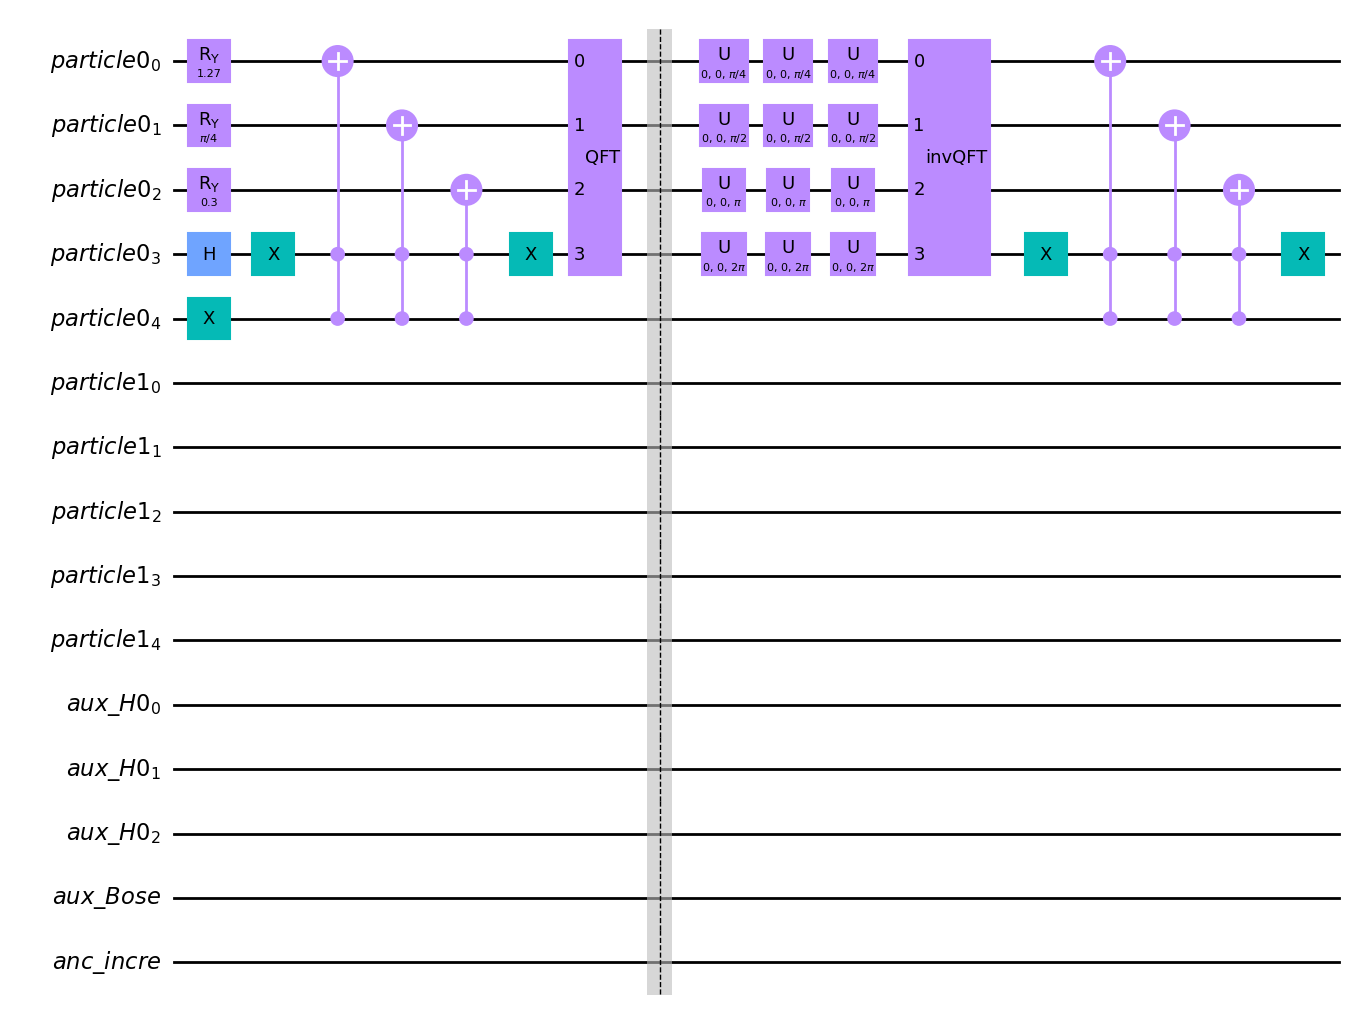

In [282]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
gauss_gate = Gaussian(1, particle_regs)
circuit.append(gauss_gate, qargs=particle_regs[0][:] + particle_regs[1][:])
sym_gate = symQFT(particle_regs[0])
circuit.append(sym_gate, qargs=particle_regs[0][:])

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 3 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心を3マス移動
circuit.barrier()
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(mom_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for iqubit in range(N_abs+1): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if mom_trans_mat[ireg][idim] > 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / 2 ** N_abs, particle_regs[ireg][iqubit])
                    # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                elif mom_trans_mat[ireg][idim] < 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / 2 ** N_abs, particle_regs[ireg][iqubit])
                    # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき


inv_sym_gate = invSymQFT(particle_regs[0])
circuit.append(inv_sym_gate, qargs=particle_regs[0][:])
circuit.decompose().draw('mpl')

In [ ]:
qft_gate = symQFT(particle_regs[0][:N_abs], particle_regs[0][N_abs:N_abs+1])
qft_gate.name = 'symQFT'
circuit.append(qft_gate, qargs=particle_regs[0][:N_abs]+particle_regs[0][N_abs:N_abs+1])
circuit.draw('mpl')

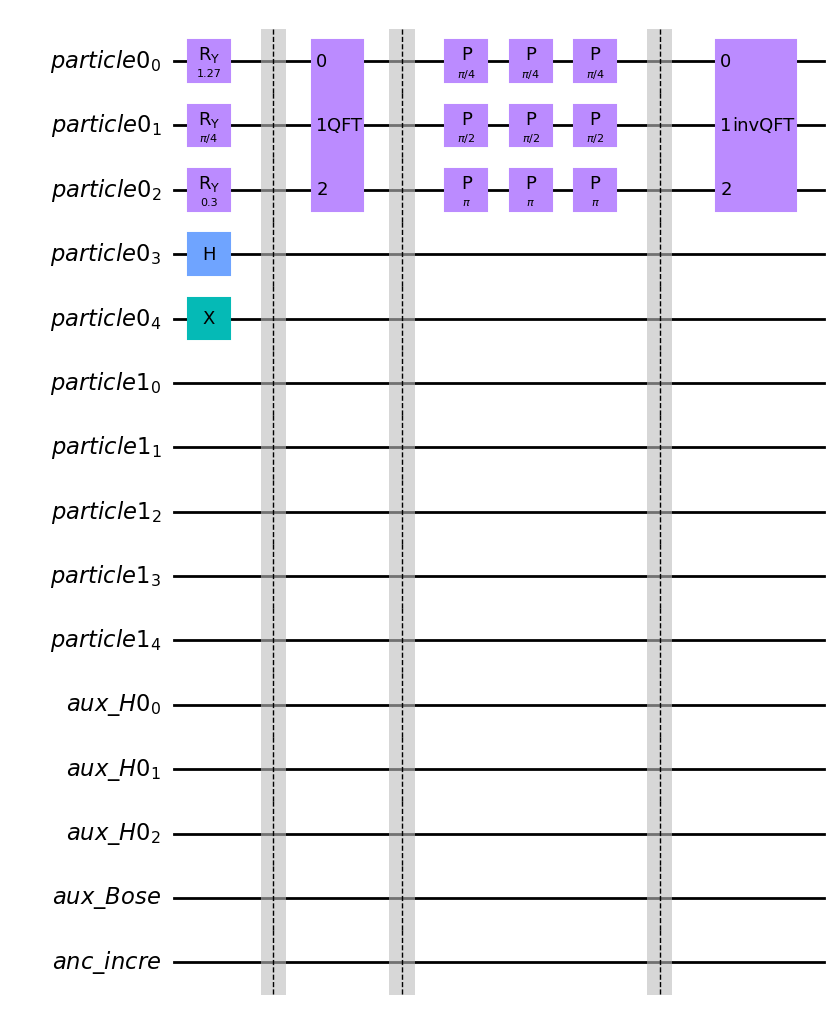

In [68]:
circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
## 上のセルと同様に, 運動量空間の重心 pbar も並進移動させる
## QFTを使うだけでやり方は全く同じ（はず）

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 3 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心を3マス移動

# QFT
for ireg in range(n):
    for idim in range(d):
        qft_gate = qFT(N_abs)
        qft_gate.name = 'QFT'
        circuit.append(qft_gate, qargs=particle_regs[ireg][:N_abs])

# momentum translation
circuit.barrier()
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(mom_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for iqubit in range(N_abs): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if mom_trans_mat[ireg][idim] > 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / 2 ** N_abs, particle_regs[ireg][iqubit])
                    # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                elif mom_trans_mat[ireg][idim] < 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / 2 ** N_abs, particle_regs[ireg][iqubit])
                    # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき

# 逆QFT
circuit.barrier()
for ireg in range(n):
    for idim in range(d):
        inv_qft_gate = invQFT(N_abs)
        inv_qft_gate.name = 'invQFT'
        circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N_abs])

circuit.draw('mpl')

In [ ]:
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
## Bose symmetrization
# n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm)
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# circuit.cx(particle_regs[1][N - 1], anc_reg_symm)

for ireg in range(M):
    for jreg in range(M):
        for iqubit in range(N):
            if ireg > jreg:
                circuit.swap(particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])

circuit.draw('mpl')

In [ ]:
#### B. Time Evolution ####
## Free Hamiltonian ##
# (全体位相がかかるだけなので要らないのでは？→ガウス型波束は時間発展ともに広がるので必要)
# まず、フーリエ変換を用いて足し算を実装→それを元にS^phiをかけていく

# circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[1][0])
# circuit.x(particle_regs[0][2])

l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

circuit.h(anc_reg_h0) # equal superposition
# addition
for reg_ctrl in particle_regs:
    for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
        for itarg, qtarg in enumerate(anc_reg_h0):
            circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
        circuit.barrier()

# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])
circuit.barrier()

circuit.draw('mpl')

In [33]:
# |phi>|q1>|q2>...という状態なので, S_phiを構成するゲートを作る（普通のゲートと制御ゲートを作る）
def sPhiGate(anc_reg_h0):
    s_circuit = QuantumCircuit(anc_reg_h0)
    for ianc, qanc in enumerate(anc_reg_h0):
        dphi = -delta_0 / M
        s_circuit.p(dphi * (2 ** ianc), qanc)
    s_gate = s_circuit.to_gate()
    cs_gate = s_gate.control(1)
    return s_gate, cs_gate

In [ ]:
circuit.barrier()
s_gate, cs_gate = sPhiGate(anc_reg_h0)
s_gate.name = 'Sphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)
for iregs in range(M):
    circuit.x(particle_regs[iregs][N - 1])
    circuit.append(cs_gate, qargs=([particle_regs[iregs][N - 1]] + anc_reg_h0[:])) # n_omegaの数だけS_phiを作用
    circuit.x(particle_regs[iregs][N - 1])
circuit.draw('mpl')
# phiをuncomputeする必要あり？

In [13]:
#### Squeezing transformation ####

In [36]:
def increGate(reg_size):
    inc_num = reg_size
    inc_circuit = QuantumCircuit(inc_num + 1)
    inc_circuit.x(inc_num)
    for iqubit in range(inc_num):
        inc_circuit.cx(inc_num, iqubit)
        if iqubit > 0:
            inc_circuit.x(range(iqubit))
        if iqubit == inc_num:
            inc_circuit.x(inc_num - 1)
            inc_circuit.x(inc_num)
        inc_circuit.mcx(list(range(iqubit + 1)), inc_num)
        if iqubit > 0:
            inc_circuit.x(range(iqubit))
        if iqubit == inc_num:
            inc_circuit.x(inc_num - 1)
            inc_circuit.x(inc_num)
    inc_gate = inc_circuit.to_gate()
    return inc_gate


In [42]:
## example and visualization of increment operation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)
# inc_gate= increGate(particle_regs[0].size)
# circuit.x(particle_regs[1][1])
# circuit.append(inc_gate, qargs=particle_regs[1][:] + [anc_incre])
# circuit.decompose.draw('mpl')

In [37]:
# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def squeeze(qmode, ireg, jreg): # まだ実装中
    nfrak = 2 * ireg.size
    reg_list = [ireg, jreg]
    ancilla = AncillaRegister(1)
    sq_circuit = QuantumCircuit(*reg_list, ancilla)
    modebits = len(bin(qmode)[2:])
    for ibit in range(modebits): # flip qubits to make |qi>|-qj> <=> |11...1>
        targ_bit = int(bin(qmode)[2 + ibit])
        sq_circuit.cx(ireg[N_abs+1], ireg[targ_bit])
        sq_circuit.cx(jreg[N_abs+1], jreg[targ_bit])
        sq_circuit.cx(jreg[N_abs + d - 1], jreg[targ_bit]) # because flip sign qubit of jth particle register
    inc_gate = increGate(nfrak)
    inc_gate.name = f'increment gate'
    sq_circuit.append(inc_gate, qargs=ireg[:] + jreg[:] + ancilla[:])
    
    # reverse states
    # for ibit in range(modebits):
    #     targ_bit = int(bin(qmode)[2 + ibit])
    #     sq_circuit.cx(ireg[N_abs+1], ireg[targ_bit])
    #     sq_circuit.cx(jreg[N_abs+1], jreg[targ_bit])
    #     sq_circuit.cx(jreg[N_abs + d - 1], jreg[targ_bit]) # because flip sign qubit of jth particle register
    return sq_circuit


In [ ]:
circuit, particle_regs, anc_reg_h0, anc_reg_symm, anc_incre = init(M, N_abs, d)

for imode in range(2 ** N_abs):
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            if inum != jnum:
                print(imode)
                print(ireg)
                print(jreg)
                sq_gate = squeeze(imode, ireg, jreg)
                sq_gate.decompose()
                circuit.append(sq_gate, qargs=ireg[:] + jreg[:] + anc_incre[:])
                circuit.barrier()

circuit.decompose().draw('mpl')

In [ ]:
# # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# print(statevector)

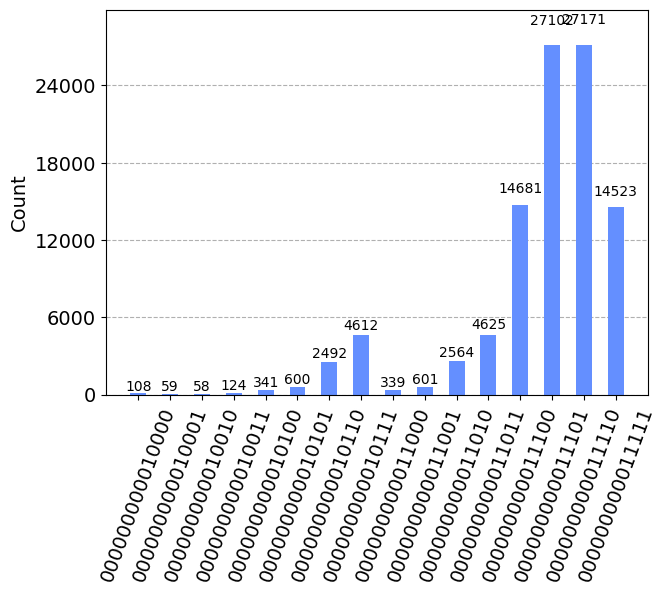

In [283]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)